# Navigation and Astrometry Comparison



## photutils vs pylanetary
Compare io-full-flux-model.ipynb (Astropy photutils) and navigate-frames.ipynb (Pylanetary) retrieved disk center pixel and Emakong location

In [8]:
import numpy as np
import matplotlib.pyplot as plt
e0 = np.load('diagnostic_data/latlon_fluxmodel.npy')
e1 = np.load('diagnostic_data/latlon_nav.npy')

d0 = np.load('diagnostic_data/xy_fluxmodel.npy')
d1 = np.load('diagnostic_data/xy_nav.npy')

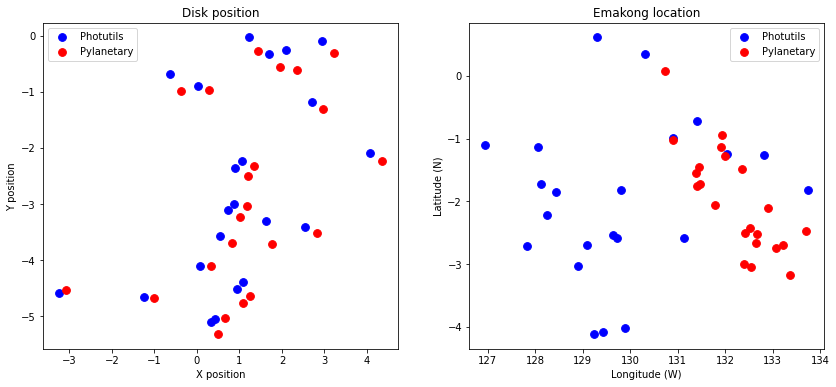

In [9]:
fig, (ax1, ax0) = plt.subplots(1,2, figsize = (14, 6))

sz = 60
ax0.scatter(e0[0], e0[1], label='Photutils', color = 'blue', s= sz)
ax0.scatter(e1[0]-1, e1[1]-1, label='Pylanetary', color = 'red', s= sz)
ax0.set_xlabel('Longitude (W)')
ax0.set_ylabel('Latitude (N)')
ax0.set_title('Emakong location')
ax0.legend()

ax1.scatter(d0[0], d0[1], label='Photutils', color = 'blue', s= sz)
ax1.scatter(d1[0]-1, d1[1]-1, label='Pylanetary', color = 'red', s= sz)
ax1.set_xlabel('X position')
ax1.set_ylabel('Y position')
ax1.set_title('Disk position')
ax1.legend()

fig.savefig('diagnostic_plots/compare_workflows.png', dpi=300)
plt.show()

### Thoughts

- one-pixel offset between pylanetary and photutils absolutely must be tracked down
- why does the Pylanetary technique decrease the uncertainty in the Emakong location?
    - Pylanetary makes it look like disk position uncertainty is due to tip-tilt jitter and offsets whole image in same direction, including position of Emakong
    - Photutils makes it look like disk position uncertainty is due to random noise making retrieval of location uncertain, and is uncorrelated with position of Emakong
    - but Pylanetary could just be due to systematics somehow
- possible solution is to back out the expected x,y position of Emakong based on its motion across the disk.
    - annoying, but maybe take average lat-lon and average disk x,y and make a Nav solution for that

## combined-disk-solution.ipynb vs theoretical-interferogram.ipynb

Comparison between using an average standard star PSF to get Emakong astrometry and using a theoretical PSF that permits phase offsets.

(2, 38) (2, 38)
Old sigma: 0.96 degrees, New sigma: 0.93


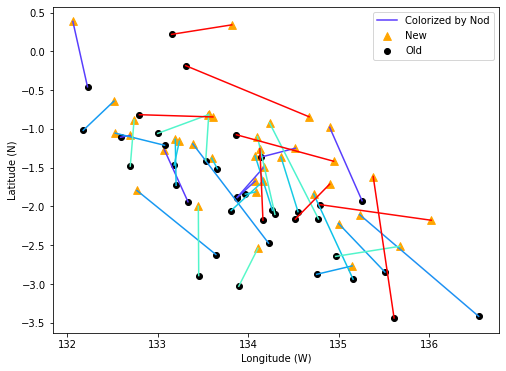

In [14]:
import paths
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

in0 = np.load(paths.data / 'latlon_theoretical-interferogram.npy')
in1 = np.load(paths.data / 'latlon_combined-disk-solution.npy')
lucky_angles = np.load(paths.data / 'lucky_angles.npy')

print(in0.shape, in1.shape)
print(f'Old sigma: {np.std(in1[0]):.2f} degrees, New sigma: {np.std(in0[0]):.2f}')

fig, ax = plt.subplots(1,1, figsize = (8,6))

for i in range(len(in0[0])):
    
    lon_pair = [in0[0,i], in1[0, i]]
    lat_pair = [in0[1,i], in1[1, i]]
    cmap = cm.rainbow
    color = cmap(lucky_angles[i]/np.max(lucky_angles))
    if i == 0:
        label = 'Colorized by Nod'
    else:
        label = ''
    ax.plot(lon_pair, lat_pair, color=color, label=label)
    
ax.scatter(in0[0], in0[1], marker = '^', c='orange', label='New', s=60)
ax.scatter(in1[0], in1[1], c='k', label='Old')
ax.legend()
ax.set_xlabel('Longitude (W)')
ax.set_ylabel('Latitude (N)')
fig.savefig('diagnostic_plots/theoretical_interferogram/latlon_change.png', dpi=300)
plt.show()

Qualitatively, and paradoxically, it looks like this improved things in the y-direction. Test this

In [11]:
## linear regression on the lat/lon to see the error in the direction of the baseline
from scipy.stats import linregress
from scipy import odr
emakong_lon = np.array(in0[0])
emakong_lat = np.array(in0[1])

# typical linear regression
slope, intercept, r, p, se = linregress(emakong_lon, emakong_lat)
lon_grid = np.linspace(131, 137, 100)
linfit = slope*lon_grid + intercept
print(f'Linear regression m, b = {slope:.2f}, {intercept:.2f}')

# orthogonal distance regression
def f(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x + B[1]


def distance(point,B):
    '''
    https://en.wikipedia.org/wiki/Distance_from_a_point_to_a_line
    find shortest distance from point to line defined by mx+b
    
    Parameters
    ----------
    point: [x,y]
    B: [m, b] as above
    '''
    return -((B[0]*point[0])-point[1]+B[1])/np.sqrt(B[0]**2+1)

def intersection_x(point,B):
    '''
    https://en.wikipedia.org/wiki/Distance_from_a_point_to_a_line
    find the value of the x-coordinate at the intersection point on the line
    
    Parameters
    ----------
    point: [x,y]
    B: [m, b] as above
    '''
    numerator = point[0] + B[0]*point[1] - B[0]*B[1]
    denominator = B[0]**2+1
    return numerator / denominator


def intersection_y(point,B):
    return B[0]*intersection_x(point,B) + B[1]

linear = odr.Model(f)
mydata = odr.Data(emakong_lon, emakong_lat)
myodr = odr.ODR(mydata, linear, beta0=[slope, intercept])
myoutput = myodr.run()
#myoutput.pprint()
B = myoutput.beta
linfit_2 = B[0]*lon_grid + B[1]
print(f'ODR regression m, b = {B[0]:.2f}, {B[1]:.2f}')

Linear regression m, b = -0.42, 54.83
ODR regression m, b = -0.57, 74.94


NameError: name 'emakong_x' is not defined

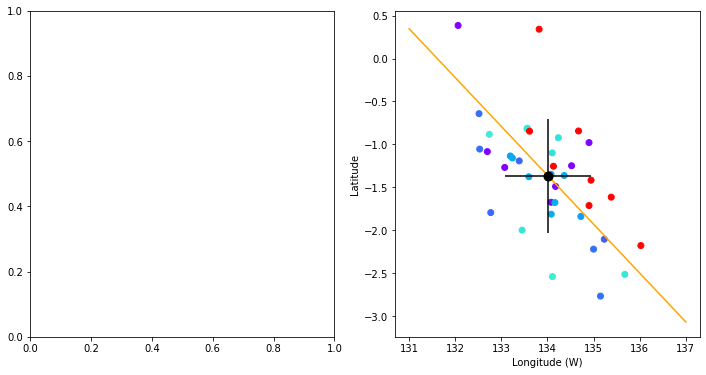

In [12]:
colors = np.copy(lucky_angles)
fig, (ax1, ax0) = plt.subplots(1,2, figsize = (12, 6))

ax0.errorbar(np.mean(emakong_lon), np.mean(emakong_lat), xerr=np.std(emakong_lon), yerr=np.std(emakong_lat), 
             color = 'k', marker = '.', markersize=18)
sc = ax0.scatter(emakong_lon, emakong_lat, c=colors, cmap = 'rainbow')
#ax0.plot(lon_grid, linfit, color = 'yellow')
ax0.plot(lon_grid, linfit_2, color = 'orange')
ax0.set_xlabel('Longitude (W)')
ax0.set_ylabel('Latitude')

ax1.scatter(np.array(emakong_x)/z, np.array(emakong_y)/z,c=colors, cmap = 'rainbow')
ax1.errorbar(np.array(emakong_x)/z, np.array(emakong_y)/z, 
             xerr=np.array(emakong_xsig)/z, 
             yerr=np.array(emakong_ysig)/z,
            color='gray', linestyle='', alpha=0.5) 
ax1.set_xlabel('Pixel X')
ax1.set_ylabel('Pixel Y')

plt.colorbar(sc, label='parallactic angle')
plt.show()

print(f'Longitude (W): {np.nanmean(emakong_lon):.1f} +/- {np.nanstd(emakong_lon):.1f} degrees')
print(f'Latitude (N): {np.nanmean(emakong_lat):.1f} +/- {np.nanstd(emakong_lat):.1f} degrees')
deg_per_px = nav.deg_per_px*z
print(f'Pixel scale: {deg_per_px:.2f} degrees per pixel')

out = np.array([emakong_lon, emakong_lat])

Standard deviation in Y residual = 0.48 degrees
Standard deviation in X residual = 0.90 degrees


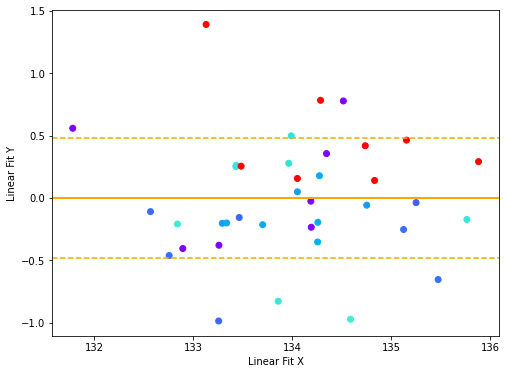

In [13]:
points = np.array([emakong_lon,emakong_lat])
resid_y = distance(points, B)
resid_x = intersection_x(points, B)
i_y = intersection_y(points, B)

resid_yerr = np.std(resid_y)
resid_xerr = np.std(resid_x)
#ysig_resid = (np.array(emakong_ysig)/z)*deg_per_px
#xsig_resid = (np.array(emakong_xsig)/z)*deg_per_px
print(f'Standard deviation in Y residual = {resid_yerr:.2f} degrees')
#print(f'Average single-fit error in Y direction = {np.mean(yerr_resid):.2f} degrees')
print(f'Standard deviation in X residual = {resid_xerr:.2f} degrees')
#print(f'Average single-fit error in X direction = {np.mean(xsig_resid):.2f} degrees')

fig, ax = plt.subplots(1,1, figsize = (8,6))
ax.scatter(resid_x, resid_y,  
            marker='o', c=colors, cmap='rainbow')
#ax.errorbar(resid_x, resid_y, 
#            yerr = ysig_resid, 
#            xerr = xsig_resid, 
#            linestyle='', color='gray', alpha=0.5)
ax.axhline(0, linestyle='-', color = 'orange', linewidth = 2)
ax.axhline(-resid_yerr, linestyle='--', color = 'orange')
ax.axhline(resid_yerr, linestyle='--', color = 'orange')
ax.set_xlabel('Linear Fit X')
ax.set_ylabel('Linear Fit Y')
plt.show()

All of this made very little difference in the result. The spread is the same as it was